In [2]:
%load_ext tensorboard
import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import numpy as np
import dataset


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [22]:
import importlib
importlib.reload(dataset) 

MAXLEN = 60
BATCH_SIZE = 64  # 512
files = ['texts/short_table.txt', 'texts/treasure_island.txt', 'texts/ahava.txt', 'texts/rambam_mamre.txt', 'texts/ali_baba.txt', 'texts/bible.txt']

data = dataset.load_file(BATCH_SIZE, 0.1, maxlen=MAXLEN, filenames=files)


In [23]:
l2 = tf.keras.regularizers.l2

EMBED_DIM = 2**10  # larger -> quicker opening. knee at 1024

inp = tf.keras.Input(shape=(data.input_texts.shape[1],), batch_size=BATCH_SIZE)

h = layers.Embedding(len(data.letters_table), EMBED_DIM, mask_zero=True)(inp)
# h = layers.Dropout(DROP)(h)

h = layers.Bidirectional(layers.GRU(256, return_sequences=True, recurrent_regularizer=None), merge_mode='sum')(h)  # =l2(1e-6)
h = layers.Dropout(0.5)(h) 

h = layers.Bidirectional(layers.GRU(256, return_sequences=True, recurrent_regularizer=None), merge_mode='sum')(h)
h = layers.Dropout(0.5)(h) 

# h = h1  # layers.Add()([h1, h])
    
h = layers.Dense(256, activation='relu', kernel_regularizer=l2(5e-5))(h)
h = layers.Dropout(0.5)(h) 
#h = layers.Add()([h1, h])
# for k in range(1):
#     h = layers.Add()([h, Dense(256)(h)])

output_niqqud= layers.Dense(data.niqqud_texts.shape[2])(h)
model_niqqud = tf.keras.Model(inputs=[inp], outputs=[h])
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_niqqud.compile(loss='mean_squared_logarithmic_error', optimizer=adam, metrics=['accuracy'])

plot_model(model_niqqud, to_file='model.png')
model_niqqud.summary()


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(64, 60)]                0         
_________________________________________________________________
embedding_4 (Embedding)      (64, 60, 1024)            74752     
_________________________________________________________________
bidirectional_8 (Bidirection (64, 60, 256)             1969152   
_________________________________________________________________
dropout_12 (Dropout)         (64, 60, 256)             0         
_________________________________________________________________
bidirectional_9 (Bidirection (64, 60, 256)             789504    
_________________________________________________________________
dropout_13 (Dropout)         (64, 60, 256)             0         
_________________________________________________________________
dense_8 (Dense)              (64, 60, 256)             6579

In [24]:

log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
def fit(EPOCHS):
    return model_niqqud.fit(data.input_texts, data.niqqud_texts,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(data.input_validation, data.niqqud_validation),
          callbacks=[
              # tf.keras.callbacks.ModelCheckpoint(filepath='niqqud_checkpoints/ckpt_{epoch}', save_weights_only=True),
              tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2, verbose=1),
              tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=0, min_lr=0.0001),
              # tensorboard_callback,
          ]
    )

history = fit(EPOCHS=15)

Train on 107769 samples, validate on 11975 samples
Epoch 1/15
107769/107769 [==============================] - 120s 1ms/sample - loss: 0.0075 - accuracy: 0.8389 - val_loss: 0.0039 - val_accuracy: 0.9172
Epoch 2/15
107769/107769 [==============================] - 107s 988us/sample - loss: 0.0039 - accuracy: 0.9193 - val_loss: 0.0030 - val_accuracy: 0.9393
Epoch 3/15
107769/107769 [==============================] - 107s 996us/sample - loss: 0.0033 - accuracy: 0.9339 - val_loss: 0.0027 - val_accuracy: 0.9463
Epoch 4/15
107769/107769 [==============================] - 108s 1000us/sample - loss: 0.0030 - accuracy: 0.9401 - val_loss: 0.0025 - val_accuracy: 0.9499
Epoch 5/15
107769/107769 [==============================] - 107s 993us/sample - loss: 0.0028 - accuracy: 0.9440 - val_loss: 0.0024 - val_accuracy: 0.9521
Epoch 6/15
107769/107769 [==============================] - 108s 1ms/sample - loss: 0.0027 - accuracy: 0.9466 - val_loss: 0.0024 - val_accuracy: 0.9537
Epoch 7/15
107769/107769 [==

In [ ]:
history1 = fit(EPOCHS=5)

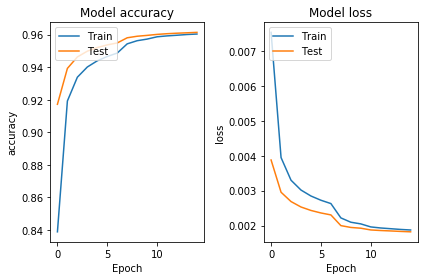

In [25]:
import matplotlib.pyplot as plt

for n, v in enumerate(['accuracy', 'loss'], 1):
    plt.subplot(1, 2, n)
    plt.plot(history.history[v][0:])
    plt.plot(history.history['val_' +  v][0:])
    plt.title('Model ' + v)
    plt.ylabel(v)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
plt.tight_layout()

In [26]:

model = tf.keras.Model(inputs=[inp], outputs=[tf.keras.layers.Softmax()(h)])

def print_predictions(k):
    s = slice(k*BATCH_SIZE, (k+1)*BATCH_SIZE)
    batch = data.input_validation[s]
    actual = model.predict(batch)
    expected = data.niqqud_validation[s]
    for a, e in zip(data.merge(batch, ns=actual), data.merge(batch, ns=expected)):
        print(a)
        print(e)
        print()

print_predictions(2)

אָבִיו אַחַר חֲצוֹת אַרְבָעָה עָשָר; אֲבָל אִם מֵת אָבִיו קֹדֶם חֲצוֹת--הֲרֵי זֶה
אָבִיו אַחַר חֲצוֹת אַרְבָעָה עָשָר; אֲבָל אִם מֵת אָבִיו קֹדֶם חֲצוֹת--הֲרֵי זֶה

וְלֹא יָצָא דָם, אֵין כָאן בְתוּלִים--שֶכָל בְתוּלָה, יֵש לָה דָם, בֵין קְטַנָה
וְלֹא יָצָא דָם, אֵין כָאן בְתוּלִים--שֶכָל בְתוּלָה, יֵש לָה דָם, בֵין קְטַנָה

לַשָדֶה--הוֹאִיל וְאֵינוּ יָכוֹל לְסַלְקוֹ--הֲרֵי הוּא כְכָל אָדָם, וְאָסוּר
לַשָדֶה--הוֹאִיל וְאֵינוּ יָכוֹל לְסַלְקוֹ--הֲרֵי הוּא כְכָל אָדָם, וְאָסוּר

"כָל-הָאֶזְרָח יַעֲשֶה-כָכָה" (במדבר טו,יג); אֲבָל נִסְכֵיהֶם קְרָבִין
"כָל-הָאֶזְרָח יַעֲשֶה-כָכָה" (במדבר טו,יג); אֲבָל נִסְכֵיהֶם קְרֵבִין

שְבוּעָה וְאֵינוּ יָכוֹל לִשָבַע, וּמְשַלֵם כְמוֹ שֶיִתְבָאַר. [ז] מֵת אָבִיו, וְהִנִיחַ
שְבוּעָה וְאֵינוּ יָכוֹל לִשָבַע, וּמְשַלֵם כְמוֹ שֶיִתְבָאַר. [ז] מֵת אָבִיו, וְהִנִיחַ

עַל-הַסֵפֶר הַזֶה וַיֵלֶךְ חִלְקִיָהוּ וַאֲשֶר הַמֶלֶךְ אֶל-חֶלְדָה הַנְבִיאָה אֵשֶת שָלֵם
עַל-הַסֵפֶר הַזֶה וַיֵלֶךְ חִלְקִיָהוּ וַאֲשֶר הַמֶלֶךְ אֶל-חֻלְדָה הַנְבִיאָה אֵשֶת שַלֻם

חָטָא-שְלֹמֹה 

In [ ]:
# model.load_weights(tf.train.latest_checkpoint('niqqud_checkpoints/'))

In [ ]:
print(history.history['val_accuracy'])

In [ ]:
%tensorboard --logdir logs\fit